In [1]:
import os

os.environ["PYSYN_CDBS"] = "/home/ruizhew/POSEIDON/inputs/stellar_grids/"
os.environ["POSEIDON_input_data"] = "/home/ruizhew/POSEIDON/inputs/"

In [21]:
from __future__ import absolute_import, unicode_literals, print_function
from POSEIDON.high_res import (
    fast_filter,
    get_rot_kernel,
    fit_uncertainties,
)
import math, os
import numpy as np
import pickle
import pickle
from scipy import constants
from numba import jit
from astropy.io import fits
from scipy import interpolate
from POSEIDON.core import (
    create_star,
    create_planet,
    define_model,
    make_atmosphere,
    read_opacities,
    wl_grid_constant_R,
    wl_grid_line_by_line,
    compute_spectrum,
)
from POSEIDON.constants import R_Sun
from POSEIDON.visuals import plot_stellar_flux
from POSEIDON.constants import R_J, M_J
import numpy as np
from spectres import spectres
from tqdm import tqdm
from multiprocessing import Pool
import time

# ***** Define stellar properties *****#


R_s = 1.21 * R_Sun  # Stellar radius (m)
T_s = 5605.0  # Stellar effective temperature (K)
Met_s = -0.04  # Stellar metallicity [log10(Fe/H_star / Fe/H_solar)]
log_g_s = 4.56  # Stellar log surface gravity (log10(cm/s^2) by convention)
# ***** Define planet properties *****#

planet_name = "WASP-77Ab"  # Planet name used for plots, output files etc.

R_p = 1.21 * R_J  # Planetary radius (m)
M_p = 0.07 * M_J  # Mass of planet (kg)
g_p = 4.3712  # Gravitational field of planet (m/s^2)
T_eq = 1043.8  # Equilibrium temperature (K)

# Create the planet object
planet = create_planet(planet_name, R_p, mass=M_p, gravity=g_p, T_eq=T_eq)

# If distance not specified, use fiducial value
if planet["system_distance"] is None:
    planet["system_distance"] = 1  # This value only used for flux ratios, so it cancels
d = planet["system_distance"]

# %%
from POSEIDON.core import define_model, wl_grid_constant_R
from POSEIDON.utility import read_high_res_data

# ***** Define model *****#

model_name = "H2O, CO retrieval"  # Model name used for plots, output files etc.

bulk_species = ["H2", "He"]  # H2 + He comprises the bulk atmosphere
param_species = ["H2O", "CO2", "CO", "CH4"]

method = "pca"
# high_res_params = ['a', 'b', 'dPhi', 'K_p', 'V_sys', 'W_conv']
high_res_params = ["a", "K_p", "V_sys"]

# Create the model object
# model = define_model(model_name, bulk_species, param_species,
#                     PT_profile = 'Madhu', high_res = high_res,
#                     high_res_params = high_res_params, R_p_ref_enabled=False)

model = define_model(
    model_name,
    bulk_species,
    param_species,
    PT_profile="Madhu",
    high_res_params=high_res_params,
)

# Check the free parameters defining this model
print("Free parameters: " + str(model["param_names"]))

# ***** Wavelength grid *****#

wl_min = 1.3  # Minimum wavelength (um)
wl_max = 2.6  # Maximum wavelength (um)
R = 250000  # Spectral resolution of grid

model["R"] = R
model["R_instrument"] = 66000  # Resolution of instrument

wl = wl_grid_constant_R(wl_min, wl_max, R)

# Create the stellar object
star = create_star(R_s, T_s, log_g_s, Met_s, wl=wl, stellar_grid="phoenix")
F_s = star["F_star"]
wl_s = star["wl_star"]

data_dir = "./data/WASP-77Ab/"

data = read_high_res_data(data_dir, method="pca", spectrum_type="emission")
data["V_sin_i"] = 4.5
model["W_conv"] = 401
opacity_treatment = "opacity_sampling"


# ***** Read opacity data *****#

opacity_treatment = "opacity_sampling"

# Define fine temperature grid (K)
T_fine_min = 2000  # 400 K lower limit suffices for a typical hot Jupiter
T_fine_max = 4000  # 2000 K upper limit suffices for a typical hot Jupiter
T_fine_step = 20  # 20 K steps are a good tradeoff between accuracy and RAM

T_fine = np.arange(T_fine_min, (T_fine_max + T_fine_step), T_fine_step)

# Define fine pressure grid (log10(P/bar))
log_P_fine_min = -5.0  # 1 ubar is the lowest pressure in the opacity database
log_P_fine_max = 2  # 100 bar is the highest pressure in the opacity database
log_P_fine_step = 0.2  # 0.2 dex steps are a good tradeoff between accuracy and RAM

log_P_fine = np.arange(
    log_P_fine_min, (log_P_fine_max + log_P_fine_step), log_P_fine_step
)

# Now we can pre-interpolate the sampled opacities (may take up to a minute)
opac = read_opacities(model, wl, opacity_treatment, T_fine, log_P_fine)

# ***** Specify fixed atmospheric settings for retrieval *****#
# Specify the pressure grid of the atmosphere
P_min = 1.0e-5  # 0.1 ubar
P_max = 100  # 100 bar
N_layers = 100  # 100 layers

# We'll space the layers uniformly in log-pressure
P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)

# Specify the reference pressure and radius
P_ref = 1e-5  # Reference pressure (bar)
R_p_ref = R_p  # Radius at reference pressure


params = (-6, -6, -6, -6, 0.3, 0.3, -1, -2, 1, 3000)
log_H2O, log_CO, log_CO2, log_CH4, a1, a2, log_P1, log_P2, log_P3, T_ref = params

PT_params = np.array([a1, a2, log_P1, log_P2, log_P3, T_ref])
log_X_params = np.array([[log_H2O, log_CO, log_CO2, log_CH4]])

atmosphere = make_atmosphere(planet, model, P, P_ref, R_p_ref, PT_params, log_X_params)

# Generate planet surface flux
F_p_obs = compute_spectrum(
    planet, star, model, atmosphere, opac, wl, spectrum_type="direct_emission"
)

Free parameters: ['R_p_ref' 'a1' 'a2' 'log_P1' 'log_P2' 'log_P3' 'T_ref' 'log_H2O'
 'log_CO2' 'log_CO' 'log_CH4' 'a' 'K_p' 'V_sys']
Reading in cross sections in opacity sampling mode...
H2-H2 done
H2-He done
H2-CH4 done
CO2-H2 done
CO2-CO2 done
CO2-CH4 done


In [11]:
model_name = "Continuum"  # Model name used for plots, output files etc.

bulk_species = ["H2", "He"]  # H2 + He comprises the bulk atmosphere
param_species = []

# Create the model object
model = define_model(model_name, bulk_species, param_species, PT_profile="Madhu")
model["R_instrument"] = 66000
model["R"] = 250000
# Check the free parameters defining this model
print("Free parameters: " + str(model["param_names"]))
log_X_params = np.array([[]])
atmosphere = make_atmosphere(planet, model, P, P_ref, R_p_ref, PT_params, log_X_params)

# Generate planet surface flux
continuum = compute_spectrum(
    planet, star, model, atmosphere, opac, wl, spectrum_type="direct_emission"
)

Free parameters: ['R_p_ref' 'a1' 'a2' 'log_P1' 'log_P2' 'log_P3' 'T_ref']


In [12]:
F_s_interp = spectres(wl, wl_s, F_s)
F_s_obs = (R_s / d) ** 2 * F_s_interp  # observed flux of star on earth
model["R_instrument"] = 66000
model["R"] = 250000
# instrument profile convolution
R_instrument = model["R_instrument"]
R = model["R"]
data["V_sin_i"] = 4.5
V_sin_i = data["V_sin_i"]
rot_kernel = get_rot_kernel(V_sin_i, wl, 401)
F_p_rot = np.convolve(
    F_p_obs, rot_kernel, mode="same"
)  # calibrate for planetary rotation
xker = np.arange(-20, 21)
sigma = (R / R_instrument) / (
    2 * np.sqrt(2.0 * np.log(2.0))
)  # model is right now at R=250K.  IGRINS is at R~45K. We make gaussian that is R_model/R_IGRINS ~ 5.5
yker = np.exp(
    -0.5 * (xker / sigma) ** 2.0
)  # instrumental broadening kernel; not understand
yker /= yker.sum()
F_p_conv = np.convolve(F_p_rot, yker, mode="same")
F_s_conv = np.convolve(
    F_s_obs, yker, mode="same"
)  # no need to times (R)^2 because F_p, F_s are already observed value on Earth

In [13]:
from POSEIDON.utility import read_high_res_data
from POSEIDON.high_res import fit_uncertainties
import numpy as np
import matplotlib.pyplot as plt
import pickle

data_path = "/home/ruizhew/POSEIDON/high_res_experiments/data/WASP-77Ab/"
data = read_high_res_data(
    data_path,
    method="pca",
    spectrum_type="emission",
)
data_arr = data["data_arr"]
data_scale = data["data_scale"]
wl_grid = data["wl_grid"]
V_bary = data["V_bary"]
phi = data["phi"]
Ndet, Nphi, Npix = data_arr.shape

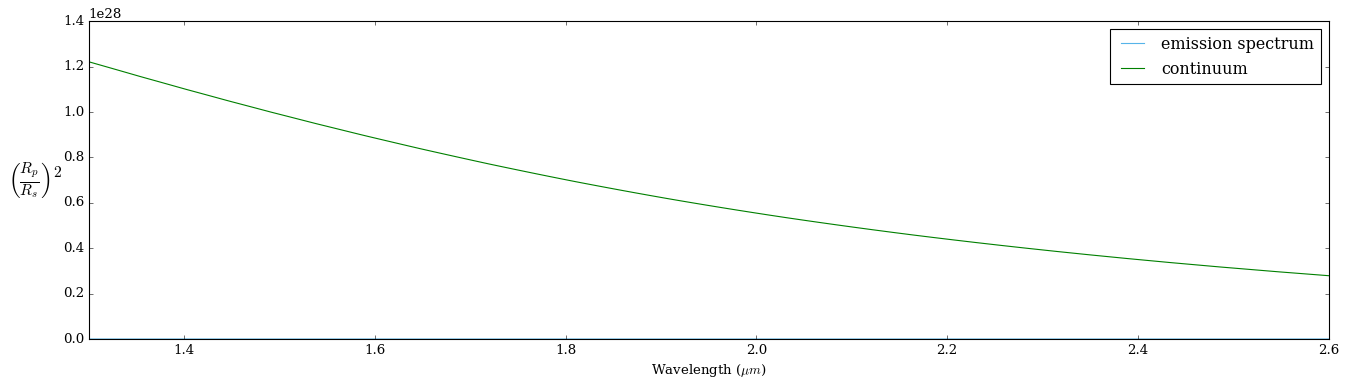

In [20]:
order_i = 15
wl_to_plot = wl_grid[order_i]
spectrum_to_plot = np.interp(wl_to_plot, wl, F_p_obs)
continuum_to_plot = np.interp(wl_to_plot, wl, continuum)
plt.figure(figsize=(17, 5))
plt.plot(wl, F_p_obs, label="emission spectrum", color="#56B4E9")
plt.plot(wl, continuum, label="continuum", color="green")
plt.xlim(np.min(wl), np.max(wl))
plt.xlabel(r"Wavelength ($\mu m$)")
plt.ylabel(
    r"$\left( \frac{R_p}{R_s} \right)^2$",
    rotation=0,
    verticalalignment="center",
    fontsize=20,
    labelpad=25,
)
plt.legend()
plt.tight_layout()
plt.ticklabel_format(useOffset=False)

In [18]:
F_p_obs

array([0.00621668, 0.00621221, 0.00622273, ..., 0.00692484, 0.0070014 ,
       0.00713262])

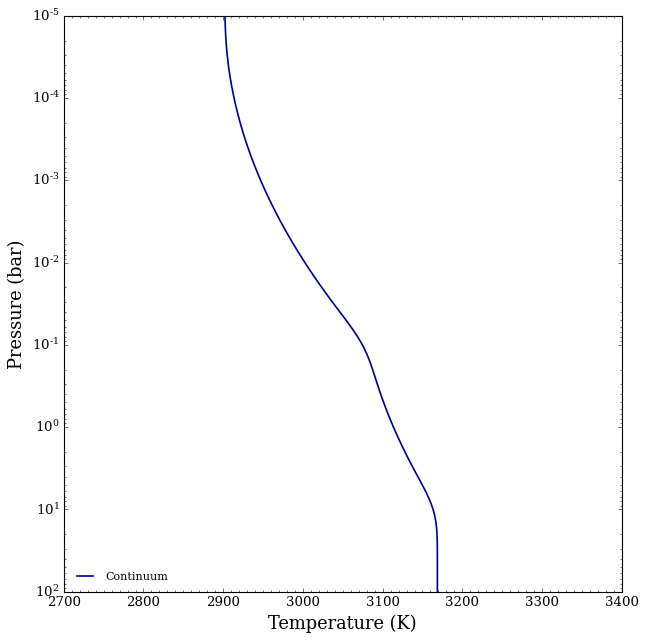

In [15]:
from POSEIDON.visuals import plot_PT

a = plot_PT(planet, model, atmosphere)

In [ ]:
import colormaps as cmaps

phi = pickle.load(open(data_path + "/phi.pic", "rb"))
# output_path = "./CC_output/WASP-77b-injection/"
# os.makedirs(output_path, exist_ok=True)

num_plots = 3
data_raw = data_arr + data_scale
fig, axes = plt.subplots(num_plots, 1, figsize=(17, num_plots * 5))
order_i = 15
order_to_plot = data_arr[order_i]
wl_to_plot = wl_grid[order_i]

im0 = axes[0].imshow(
    # order_to_plot * models_shifted[order_i] ** 3,
    order_to_plot,
    aspect="auto",
    origin="lower",
    cmap=cmaps.lapaz,
    vmin=0,
    # vmax=vmax,
    extent=[np.min(wl_to_plot), np.max(wl_to_plot), np.min(phi), np.max(phi)],
)

fig.colorbar(
    im0, ax=axes[0], orientation="vertical", pad=0.005, shrink=0.9
).formatter.set_useOffset(False)

for i in range(num_plots - 1):
    axes[i].xaxis.set_visible(False)


im1 = axes[1].imshow(
    # (residuals_to_plot + 1) * models_shifted[order_i] ** 3 - 1,
    data_arr[order_i],
    aspect="auto",
    origin="lower",
    cmap=cmaps.lapaz,
    # vmin=np.min(residuals_to_plot * models_shifted[order_i] ** 3) * 0.999,
    # vmax=np.max(residuals_to_plot * models_shifted[order_i] ** 3) * 1.001,
    extent=[np.min(wl_to_plot), np.max(wl_to_plot), np.min(phi), np.max(phi)],
)

fig.colorbar(
    im1, ax=axes[1], orientation="vertical", pad=0.005, shrink=0.9
).formatter.set_useOffset(False)

im2 = axes[2].imshow(
    model_to_plot,
    aspect="auto",
    origin="lower",
    cmap=cmaps.lapaz,
    # vmin=vmin,
    # vmax=vmax,
    extent=[np.min(wl_to_plot), np.max(wl_to_plot), np.min(phi), np.max(phi)],
)

fig.colorbar(
    im2, ax=axes[2], orientation="vertical", pad=0.005, shrink=0.9
).formatter.set_useOffset(False)


# im3 = axes[3].imshow(
#     residuals[order_i],
#     aspect="auto",
#     origin="lower",
#     cmap=cmaps.lapaz,
#     vmin=np.min(residuals[order_i]) * 0.999,
#     vmax=np.max(residuals[order_i]) * 1.001,
#     extent=[np.min(wl_to_plot), np.max(wl_to_plot), np.min(phi), np.max(phi)],
# )

plt.tight_layout()
# fig.subplots_adjust(hspace=0.02)


plt.ticklabel_format(useOffset=False)